In [403]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             confusion_matrix,
                             roc_auc_score,
                             ConfusionMatrixDisplay,
                             classification_report)

from transformers import DistilBertTokenizer
from transformers import BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup

import torch
from torch.optim import AdamW
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from tqdm.notebook import tqdm

In [4]:
torch.cuda.is_available()

True

In [40]:
df = pd.read_csv("complaints_processed.csv", index_col=0)

df

,product,narrative
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...
...,...,...
162416,debt_collection,name
162417,credit_card,name
162418,debt_collection,name
162419,credit_card,name


We have a two column dataset taken from [here](https://www.kaggle.com/datasets/shashwatwork/consume-complaints-dataset-fo-nlp). This data is taken from the Consumer Financial Protection Bureau (CFPB). The `narrative` data comes from customers that submit complaints against financial agencies. The narratives or disputes are classified into different categories for efficient processing of the requests.

Let's examine the data a bit further.

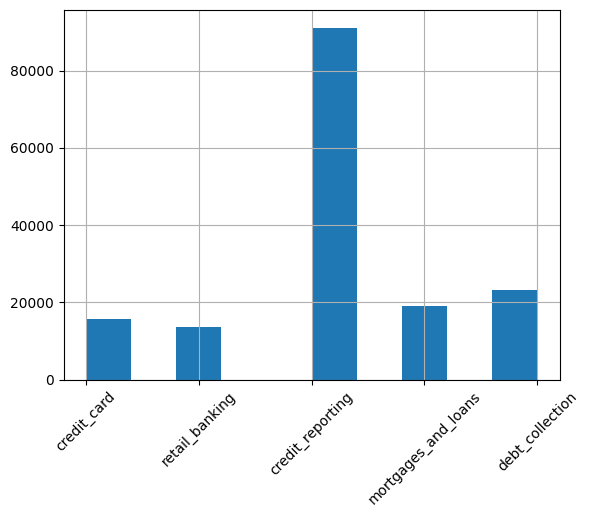

In [46]:
plt.hist(data=df, x="product")
plt.grid()
plt.xticks(rotation=45)
plt.show()

We can see that we have a lot of the narratives classified in the credit_reporting column. Let's see the normalized value counts.

In [59]:
val_counts = pd.DataFrame(df['product'].value_counts(normalize=True))
val_counts = pd.concat([val_counts, df['product'].value_counts()], axis = 1)

val_counts

,proportion,count
product,,
credit_reporting,0.561374,91179
debt_collection,0.142531,23150
mortgages_and_loans,0.116918,18990
credit_card,0.095837,15566
retail_banking,0.083339,13536


We can see that over 50% of the data is going towards *credit_reporting* while retail_banking has the least amount of narratives at about 8.3%.

In [64]:
# store the categories
categories = val_counts.index.values

Let's explore the data a bit more. We will print a few narratives and create a wordcloud for each category.

In [90]:
for cat in categories:
    curr_row = df[df["product"] == cat].iloc[0]
    print("Category:", cat, "\n")
    print("Narrative:\n\n", curr_row["narrative"], sep="")
    print("=" * 20)
    print("\n\n")

Category: credit_reporting 

Narrative:

payment history missing credit report specialized loan servicing sl made mistake put account forbearance without authorization knowledge matter fact automatic payment setup month monthly mortgage paid full noticed issue account marked forbearance credit report tried get new home loan another new bank contacted immediately asked fix error provide letter detail please see asks forbearance issue seemed fixed however credit report payment history missing new bank able approve new loan issue missing payment history contacted specialized loan servicing time since phone ask sl thing report payment history fix missing data issue provide letter show account never forbearance payment history past month however waiting week countless email phone call talk multiple supervisor able get either one thing without issue fixed new bank process new loan application therefore need sl help immediately get fixed



Category: debt_collection 

Narrative:

collection a

It's clear from the print statements above that the narratives have been preprocessed and had stop words removed.

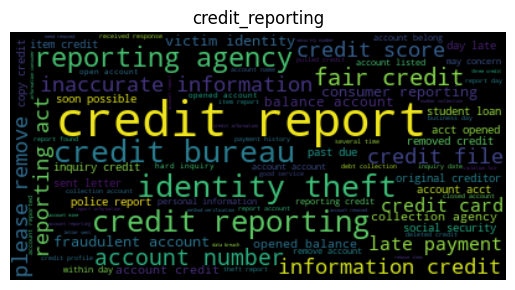

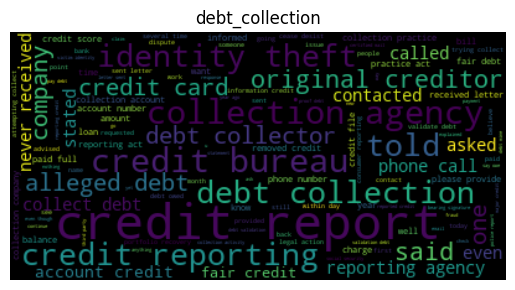

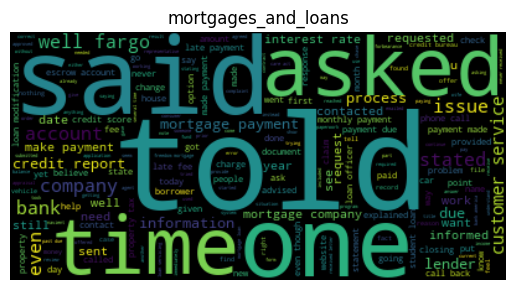

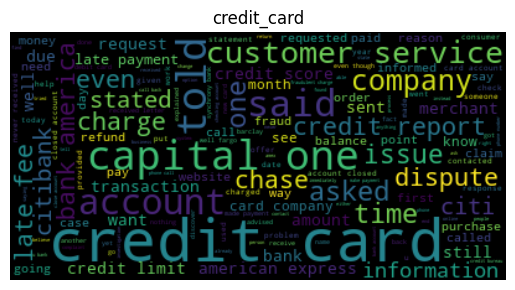

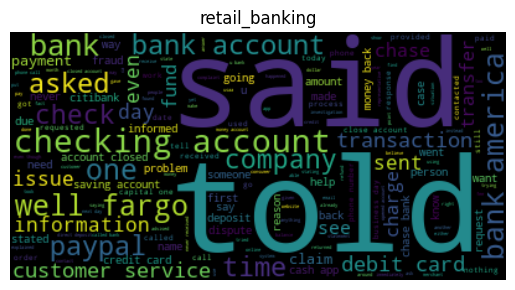

In [92]:
for cat in categories:
    curr_corpus = df[df["product"] == cat]["narrative"].str.cat(sep=" ")
    wordcloud = WordCloud().generate(curr_corpus)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(cat)
    plt.axis("off")
    plt.show()

I'm also interested to see the length of the narratives for each category. Let's plot those.

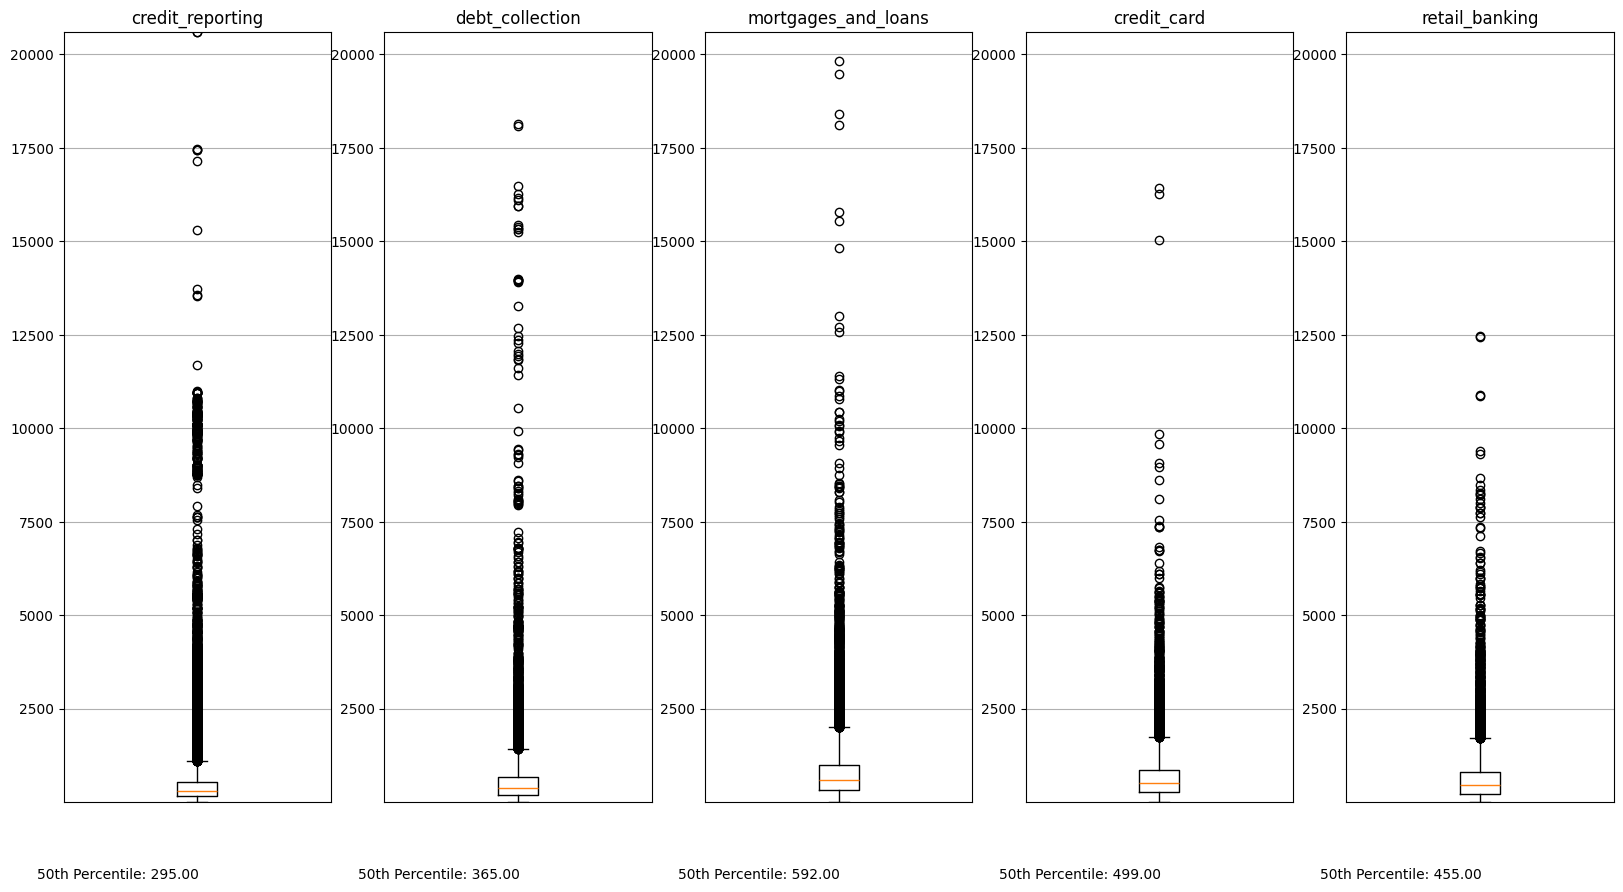

In [159]:
fig, axes = plt.subplots(1, len(categories), figsize=(20, 10))


# Initialize variables to store the minimum and maximum values for the y-axis scale
y_min = float('inf')
y_max = float('-inf')

for i, cat in enumerate(categories):
    ax = axes[i]
    data = df[df["product"] == cat]["narrative"].apply(lambda x: len(str(x)))
    ax.boxplot(data)
    ax.grid()
    ax.set_title(cat)  # Set the title for each subplot
    ax.set_xticks([])
    
    # Update y-axis scale limits
    y_min = min(y_min, min(data))
    y_max = max(y_max, max(data))
    
    percentile_50 = np.percentile(data, 50)
    
    # Add the 75th percentile value as text in the subplot
    ax.text(-0.1, -0.1, f'50th Percentile: {percentile_50:.2f}', transform=ax.transAxes, fontsize=10)
    
# Set a common y-axis scale for all subplots
for ax in axes:
    ax.set_ylim(y_min, y_max)

plt.show()

We can see that mortgages and loans tend to have longer text. We will likely be cutting most of these narratives off at some point as BERT LLM has a max_len token limit of around 512 and we'll likely be setting the value to be much smaller as it helps drastically with the processing speed and time.

We noticed when we printed the dataframe before that some narratives contain only one word. Let's examine those

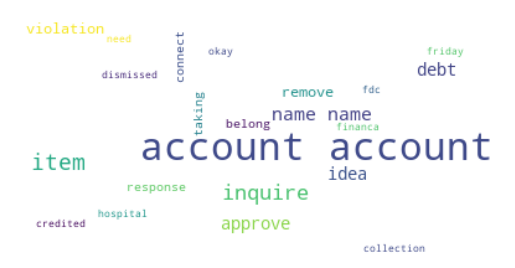

In [215]:
wordcloud = WordCloud(background_color="white").generate(df["narrative"][df["narrative"].apply(lambda x: len(str(x).split())) == 1].str.cat(sep=" "))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

We can see that most of these words aren't really informative, thus we will remove them from the dataset.  
Note that we examined narratives with 2 words and they do provide some information, thus we will keep them.

In [219]:
old_len = len(df)
df = df[df["narrative"].apply(lambda x: len(str(x).split()) > 1)]
print("removed", old_len - len(df), "rows")

removed 126 rows


Now let's remove rows with null values

In [253]:
sum(df["product"].isnull()), sum(df["narrative"].isnull())

(0, 0)

We have no null values. Let's examine the duplicates

In [233]:
sum(df.duplicated())

37645

We have a lot of duplicates. Let's examine a few to see whether they just used the same narrative that may be a template of some sorts or if there's another issue.

In [295]:
df[df.duplicated()].iloc[0]["narrative"]

'name last four s account number writing dispute late payment reported impacted hospital long time lost job spoke advised payment deferred get credit alert reported past due violation care act late payment need removed pay account full correct credit report remove erroinious late fee told provided protection care act failed adhere offered one called received written notice term deferred plan rely rep told thought protected need make right comply care act fix credit reporting remove late fee call done account negative told going forebarace would put account credit limit illegal credit ruined udapp violation care act violation'

In [297]:
df[df.duplicated()].iloc[1]["narrative"]

'open account acct opened balance account acct opened balance account closed account acct opened balance account acct opened balance account acct opened balance account acct opened balance account acct opened balance account acct opened balance account acct opened balance account acct opened balance account acct opened balance account acct opened balance account acct opened balance account'

In [242]:
df[df.duplicated(keep=False)].iloc[100]["narrative"]

'block except otherwise provided section consumer reporting agency shall block reporting information file consumer consumer identifies information resulted alleged identity theft later business day date receipt agency appropriate proof identity consumer copy identity theft report identification information consumer statement consumer information information relating transaction consumer b notification consumer reporting agency shall promptly notify furnisher information identified consumer subsection section information may result identity theft identity theft report filed block requested section effective date block c authority decline rescind general consumer reporting agency may decline block may rescind block information relating consumer section consumer reporting agency reasonably determines information blocked error block requested consumer error b information blocked block requested consumer basis material misrepresentation fact consumer relevant request block c consumer obtain

These narratives don't seem like templates to me at all. Again, the text is preprocessed so it makes it harder to assess these things. It's a bit more complicatd to develop a sophisticatd way to remove the reports that don't seem like a template or something that two people might have said verbatim. Thus we won't be removing all duplicated rows. Let's do a bit more analysis.  

By the way, *the narrative with index 1 printed above looks very weird!*

In [249]:
sum(df.duplicated(subset="narrative")), sum(df.duplicated())

(37846, 37645)

We can see something odd above in that the duplicated rows across just the `narrative` column is less than across both columns. This indicates that we have some rows where the narratives are the same and the category or `product` is different.

In [303]:
# below we set keep=False to get all the rows where the condition above applies
df_nar_duplicates = df[(df["narrative"].duplicated(keep=False) == True) & (df.duplicated(keep=False) == False)]
df_nar_duplicates[df_nar_duplicates["narrative"].duplicated(keep=False)]

,product,narrative
643,credit_reporting,writing due failed remove information affiliat...
1173,mortgages_and_loans,see late mark clear violation right fcra compa...
2961,debt_collection,account mine
3169,credit_reporting,account paid full
6531,mortgages_and_loans,amidst worldwide crisis facing going pandemic ...
...,...,...
146695,credit_reporting,unable link account
147448,credit_reporting,upon reviewing file come attention error infor...
147449,debt_collection,upon reviewing file come attention error infor...
158617,debt_collection,account holder dob fl regulation z give borrow...


In [308]:
df_nar_duplicates[df_nar_duplicates["narrative"].duplicated()].iloc[-1]["narrative"]

'account holder dob fl regulation z give borrower right cancel certain credit transaction including lien borrower dwelling regulate credit card practice provide consumer access fair timely credit billing dispute regulation z enforced federal reserve board consumer financial protection bureau however wall street reform consumer protection act transferred responsibility cfpb auntie passed away several fraudulent purchase made death bed purchase made died aunt never abused maxed credit card never gave consent anyone use credit card never authorized authorized signer account want fraudulent credit card purchase carefully reviewed want charge cancelled due fraud aunt spending pattern simple always paid full never left balance hardly never used credit card unusual spending pattern noticed negligence creditor part noticing unusual pattern large purchase personal representative estate want make sure affair order local case number filing date state case number judicial section consolidated case

In [309]:
df_nar_duplicates[df_nar_duplicates["narrative"].duplicated()].iloc[-2]["narrative"]

'upon reviewing file come attention error information appear regarding account number balance incurred acknowledgment given consent permission anyone institution use personal information obtain open account reach institution regarding matter made sure account open without permission closed remove delete please authenticate provide documentation bear original owner signature validate account within business day taken step necessary remove delete account opened owner personal information without permission according fair credit reporting act section company required federal law verify physical verification debt balance original signed certified consumer contract account request posted reported credit report within consumer right demand copy verifiable validated proof original consumer contract signature copy copy validation law considered proof fcra unverified invalid account must remove upon receipt notice within business day'

After some examination, I decided to move forward by removing all rows where the narratives are duplicated and the products are different. The reasoning behind this is that some narratives might not be discriminatory enough such that it can be used for multiple products in which case it might add noise and confusion to the model. I will keep the rows where both columns are identical because of templates. The reason is that some reporters might write the same thing as they have similar reports.

In [320]:
df.drop(df_nar_duplicates.index, inplace=True)

C:\Users\yousi\AppData\Local\Temp\ipykernel_12220\3984628247.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df_nar_duplicates.index, inplace=True)


There's always more EDA to be done, but we'll leave it here for now.  

To go back to our main topic which is fine-tuning an LLM, we'll need to code the inputs. OHE (one-hot-encoding) is the technique I recommend but given that it will likely take more time to process, I will just use LabelEncoder.  

We will be sure to use stratify when splitting the data to make sure the balances are represented in the model. However, we do worry that we will not learn enough from the categories that are underrepresented. We will test the model and if that's the case, we will look at using some other sampling techniques.

In [335]:
label_encoder = LabelEncoder()
df["product_label"] = label_encoder.fit_transform(df['product'])

C:\Users\yousi\AppData\Local\Temp\ipykernel_12220\2312488906.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["product_label"] = label_encoder.fit_transform(df['product'])


In [339]:
X_train, X_test, y_train, y_test = train_test_split(df["narrative"],
                                                    df["product_label"],
                                                    test_size=0.3,
                                                   stratify=df.product_label)

X_test, X_val, y_test, y_val = train_test_split(X_test,
                                                y_test,
                                                test_size=0.05,
                                                stratify=y_test)

We will use DistilBERT and its tokenizer. Let's prepare the data for the model by tokenizing and setting up efficient dataloaders.

In [411]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',
                                          do_lower_case=True)

batch_size = 8 # small value for faster training
max_len = 128 # smaller = faster, larger = retain more info

def prepare_dataset(X, y, train=True, batch_size=batch_size, max_len=max_len):
    encoded_data = tokenizer.batch_encode_plus(
        X.values,
        add_special_tokens=True,
        return_attention_mask=True,
        padding=True,
        max_length=max_len,
        truncation=True,
        return_tensors='pt'
    )
    
    input_ids = encoded_data['input_ids']
    attention_masks = encoded_data["attention_mask"]
    labels = torch.tensor(y.values).to(torch.long)
    
    dataset = TensorDataset(input_ids, attention_masks, labels)
    dataset_loader = DataLoader(dataset,
                                sampler=RandomSampler(dataset),
                                batch_size=batch_size) if train else( # no need to draw randomly if testing
                     DataLoader(dataset,
                                sampler=SequentialSampler(dataset),
                                batch_size=batch_size))
    return dataset_loader

In [412]:
dataloader_train      = prepare_dataset(X_train, y_train)
dataloader_validation = prepare_dataset(X_val, y_val, train=False)
dataloader_test       = prepare_dataset(X_test, y_test, train=False)

Let's load the model

In [395]:
model = BertForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                      num_labels=len(label_encoder.classes_),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['encoder.layer.9.output.dense.bias', 'encoder.layer.3.output.dense.bias', 'encoder.layer.1.attention.output.dense.weight', 'encoder.layer.9.attention.self.value.bias', 'encoder.layer.11.attention.self.value.bias', 'encoder.layer.6.attention.output.LayerNorm.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.8.attention.self.key.weight', 'encoder.layer.9.attention.self.key.weight', 'encoder.layer.5.intermediate.dense.weight', 'encoder.layer.9.attention.output.dense.weight', 'encoder.layer.6.attention.self.query.weight', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.2.attention.self.query.bias', 'encoder.layer.9.intermediate.dense.weight', 'encoder.layer.5.output

In [396]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


Let's set the optimizer and scheduler.

In [401]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

epochs = 1

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [402]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad(): # we're not updating the gradients
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [413]:
for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'finetuned_BERT_{max_len}_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    tqdm.write(f'Validation loss: {val_loss}')

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/14185 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.5090869996790927
Validation loss: 0.41263391840345176


Let's evaluate the model on the test dataset.

In [414]:
_, predictions, true_vals = evaluate(dataloader_test)
predictions_binary = np.argmax(predictions, axis=1)

In [418]:
accuracy = accuracy_score(true_vals, predictions_binary)
precision = precision_score(true_vals, predictions_binary, average="weighted")
recall = recall_score(true_vals, predictions_binary, average="weighted")
f1_score_ = f1_score(true_vals, predictions_binary, average="weighted")

print("Results using TF-IDF Vectorization and Support Vector Machine (SVM) Classifier:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score_)

Results using TF-IDF Vectorization and Support Vector Machine (SVM) Classifier:
Accuracy: 0.8673405337546807
Precision: 0.8661018298655054
Recall: 0.8673405337546807
F1 Score: 0.866284874249942


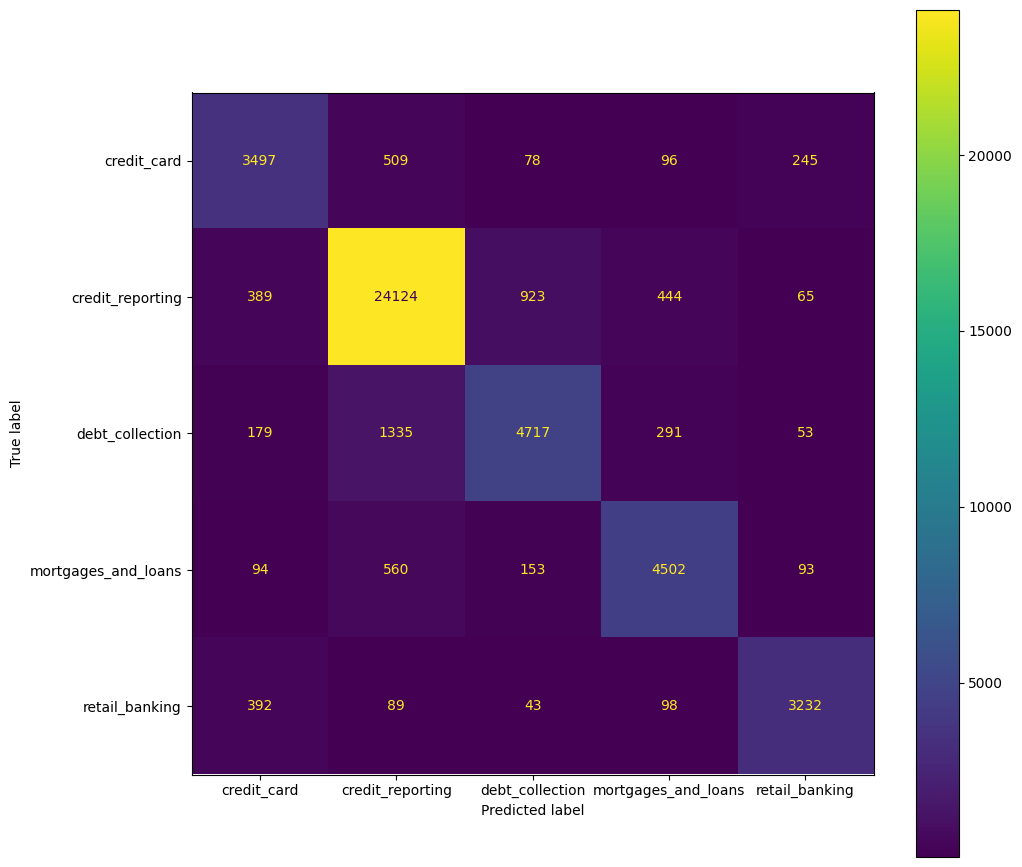

In [420]:
fig, ax = plt.subplots(figsize=(11, 11))
cm = confusion_matrix(true_vals, predictions_binary)
ConfusionMatrixDisplay(confusion_matrix=cm,
                      display_labels=label_encoder.classes_).plot(ax=ax)
plt.show()

In [421]:
print(classification_report(true_vals, predictions_binary))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      4425
           1       0.91      0.93      0.92     25945
           2       0.80      0.72      0.76      6575
           3       0.83      0.83      0.83      5402
           4       0.88      0.84      0.86      3854

    accuracy                           0.87     46201
   macro avg       0.84      0.82      0.83     46201
weighted avg       0.87      0.87      0.87     46201



The results look pretty promising to me. It expectedly performed best in the *credit_reporting* category as it has the most data by far. It would be interesting to see if we can perform better as we add more epochs. We can also try and sample differently, e.g., use undersampling to level the playing field across categories. We can also play around with hyperparameter tuning which can likely improve the performance a little bit.  
As for now, I'll leave it here.